In [1]:
import numpy as np
import h5py
import cv2
import keras
from keras.models import Sequential
from keras.layers import Input, Convolution2D, Activation, MaxPool2D, Dense,Flatten
from keras.models import Model
from keras.utils import np_utils
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.io as sio
import random
import math

Using TensorFlow backend.


In [2]:
data = sio.loadmat('../Datasets/wiki_crop/wiki.mat')


In [21]:
i=876
img_add=data['wiki'][0][0][2][0][i][0]
print img_add

65/21032065_1989-02-24_2014.jpg


(173, 173) (173, 173, 3)


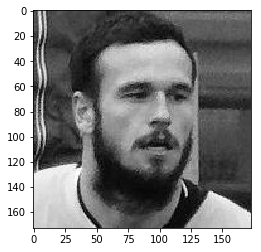

In [22]:
img = cv2.imread('../Datasets/wiki_crop/'+img_add)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img1,cmap='gray')
print img1.shape, img.shape

In [15]:
loc=data['wiki'][0][0][5][0][i][0]
print loc


[ 252.4833023   126.68165115  354.53192596  228.73027481]


0


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))


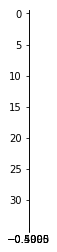

In [24]:
img_cropped = img1[int(loc[0]):int(loc[2]),int(loc[1]):int(loc[3])]
print img_cropped.shape[1]
plt.imshow(img_cropped,cmap='gray')

[[ 49  29 100 100]]


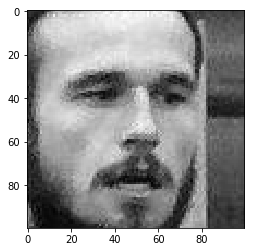

In [30]:
facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = facec.detectMultiScale(img)
print faces

for (x,y,w,h) in faces:
    img_cropped = img[y:y+h, x:x+w]
    img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    
plt.imshow(img_cropped, cmap='gray')

In [27]:
print len(faces)

1


In [5]:
max_value = data['wiki'][0][0][2][0].shape[0]/5
print max_value

12465


In [32]:
img_final = np.zeros((max_value,50,50))
train_labels = np.zeros((max_value,1))

for ix in range(max_value):
#     print ix
    #Location of Image
    img_add=data['wiki'][0][0][2][0][ix][0]
    
    #Reading Image
    img = cv2.imread('../Datasets/wiki_crop/'+img_add)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plt.imshow(img1,cmap='gray')
    
    #Gender Extraction
    gender = data['wiki'][0][0][3][0][ix]
    if math.isnan(gender):
        gender = 1
    
    #Face Extraction
#     
    facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = facec.detectMultiScale(img)
    if len(faces)!=0:
        for (x,y,w,h) in faces:
            img_cropped = img[y:y+h, x:x+w]
            img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    else:
        loc=data['wiki'][0][0][5][0][ix][0]
        img_cropped = img1[int(loc[0]):int(loc[2]),int(loc[1]):int(loc[3])]
        if img_cropped.shape[0]==0 or img_cropped.shape[1]==0:
            img_cropped=img1
    
    
    #Resizing and Final table Construction
    img_final[ix]= cv2.resize(img_cropped,(50,50))
    train_labels[ix]=gender
    

[ 0.]


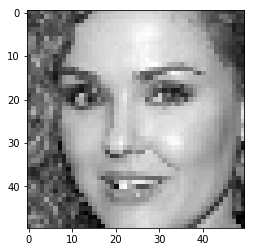

In [42]:
x = random.randint(0,max_value)
plt.imshow(img_final[x],cmap='gray')
print train_labels[x]


In [43]:
train_labs = train_labels
train_labs=np_utils.to_categorical(train_labs)
print train_labels.shape
print train_labs.shape

(12465, 1)
(12465, 2)


In [44]:
np.unique(train_labels,return_counts=True)

(array([ 0.,  1.]), array([2523, 9942]))

In [45]:
model = Sequential()

model.add(Convolution2D(32, (3, 3), input_shape=(50, 50, 1)))
model.add(Activation('relu'))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 21, 21, 64)        0         
__________

In [46]:
img_final = img_final.reshape((-1,50,50,1))

split = int(0.9*img_final.shape[0])
img_final_train=img_final[:split]
img_final_test=img_final[split:]
training_labels=train_labs[:split]
test_labels=train_labs[split:]
print img_final_train.shape, img_final_test.shape
print training_labels.shape, test_labels.shape

# model.fit(img_final, train_labs,
#          epochs=10,
#          shuffle=True,
#         batch_size=100,)

(11218, 50, 50, 1) (1247, 50, 50, 1)
(11218, 2) (1247, 2)


In [47]:
hist =model.fit(img_final, train_labs,
         epochs=3,
         shuffle=True,
        batch_size=1000,
         validation_data=(img_final_test,test_labels))

Train on 12465 samples, validate on 1247 samples
Epoch 1/3
12465/12465 [==============================] - 49s - loss: 3.3250 - acc: 0.7605 - val_loss: 3.0199 - val_acc: 0.8091
Epoch 2/3
12465/12465 [==============================] - 35s - loss: 3.1867 - acc: 0.7976 - val_loss: 3.0112 - val_acc: 0.8091
Epoch 3/3
12465/12465 [==============================] - 35s - loss: 3.1863 - acc: 0.7976 - val_loss: 3.0079 - val_acc: 0.8091


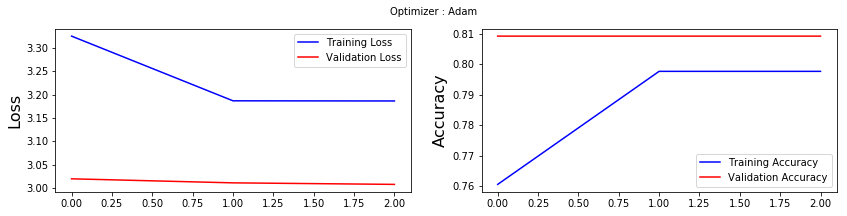

In [49]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], 'b', label='Training Loss')
plt.plot(hist.history['val_loss'], 'r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], 'b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], 'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [50]:
import h5py
model.save('gender_reco.h5')  # creates a HDF5 file 'my_model.h5'
f = h5py.File('gender_reco.h5', 'r+')
del f['optimizer_weights']
f.close()

In [51]:
gender_out_verify = model.predict(img_final_test[456].reshape((-1,50,50,1)))

In [53]:
print test_labels[1]

[ 0.  1.]


In [54]:
type(gender_out_verify)

numpy.ndarray

In [55]:
print gender_out_verify[0][1]
print gender_out_verify[0][0]

1.0
0.0
